In [1]:
import pandas as pd
import numpy as np

# import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score

from sklearn.tree import export_graphviz
import graphviz

from xgboost import XGBClassifier, plot_importance

In [3]:
TARGET = "pollutant"
DATA_PATH = "datasets"

API_URLS = [
    "http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/first",
    "http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/second",
    "http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/third"
]

DATASET_DTYPES = {
    "CITY ID": "object",
    "CONTINENT": "object",
    "City": "object",
    "DAY": "int8",
    "DAY WITH FOGS": "int8",
    "EPRTRAnnexIMainActivityCode": "object",
    "EPRTRAnnexIMainActivityLabel": "object",
    "EPRTRSectorCode": "int8",
    "FacilityInspireID": "object",
    "MONTH": "int8",
    "REPORTER NAME": "object",
    "avg_temp": "float64",
    "avg_wind_speed": "float64",
    "countryName": "object",
    "eprtrSectorName": "object",
    "facilityName": "object",
    "max_temp": "float64",
    "max_wind_speed": "float64",
    "min_temp": "float64",
    "min_wind_speed": "float64",
    "pollutant": "object",
    "reportingYear": "int8",
    "targetRelease": "object"
}

## Classes

In [4]:
class ApiDataConsumer:

    def __init__(self, urls, dtypes = None):
        self.urls = urls
        self.dtypes = dtypes

    def get_api_df(self, verbose: bool = True):
        if verbose:
            print("Getting data from API")
        api_df = None
        for url in self.urls:
            json_df = pd.read_json(url, dtype=self.dtypes)
            json_df = json_df.drop("", axis=1)

            if verbose:
                print(f"url: {url} json_df.shape: {json_df.shape}")

            if api_df is not None:
                api_df = pd.concat([api_df, json_df])
            else:
                api_df = json_df

        return api_df


class FeatureGenerator:

    def __init__(self, df: pd.DataFrame):
        self.df = df.copy(deep=True)

    def encode(self, columns, agg_func = None) -> pd.DataFrame:
        if agg_func is None:
            agg_func = self.__my_agg

        for column in columns:
            gb_df_ = self.df.groupby(column).apply(agg_func, column_name=column).reset_index()
            self.df = pd.merge(left=self.df, right=gb_df_, on=column, how="left")

        return self.df.drop(columns, axis=1)

    @staticmethod
    def __my_agg(full_df_: pd.DataFrame, column_name: str) -> pd.Series:
        column_name = column_name.replace(" ", "_").lower()
        names = {
            '{}_avg_temperature'.format(column_name):  full_df_['avg_temp'].mean(),
            '{}_avg_wind_speed'.format(column_name):  full_df_['avg_wind_speed'].mean(),
        }
        return pd.Series(names, index = [key for key in names.keys()])

## Functions

In [5]:
def one_hot_encode(dataframe: pd.DataFrame, column_name: str) -> pd.DataFrame:
    _dummy_dataset = pd.get_dummies(dataframe[column_name], prefix=column_name)
    return pd.concat([dataframe, _dummy_dataset], axis=1).drop([column_name], axis=1)

def encode_dataframe(dataframe: pd.DataFrame, cat_columns) -> pd.DataFrame:
    print(f"columns to encode: {cat_columns}")

    print(f"dataframe before one-hot encoding: {dataframe.shape}")
    for cat_col in cat_columns:
        dataframe = one_hot_encode(dataframe, cat_col)

    print(f"dataframe after one-hot encoding:  {dataframe.shape}")
    return dataframe

## Load data

In [6]:
apiDataConsumer = ApiDataConsumer(API_URLS, DATASET_DTYPES)

In [7]:
%%time
train1_df = pd.read_csv(f"{DATA_PATH}/train1.csv", dtype=DATASET_DTYPES)
print('* train1 loaded... shape:', train1_df.shape)

train2_df = pd.read_csv(f"{DATA_PATH}/train2.csv", dtype=DATASET_DTYPES, sep=";")
print('* train2 loaded... shape:', train2_df.shape)

api_df = apiDataConsumer.get_api_df(verbose=False)
print('* api_df loaded... shape:', api_df.shape)

test_x_df = pd.read_csv(f"{DATA_PATH}/test_x.csv", dtype=DATASET_DTYPES)
print('* test_x_df loaded... shape:', test_x_df.shape)


* train1 loaded... shape: (18563, 21)
* train2 loaded... shape: (18564, 21)
* api_df loaded... shape: (28501, 23)
* test_x_df loaded... shape: (24480, 23)
CPU times: user 1.94 s, sys: 450 ms, total: 2.39 s
Wall time: 5.45 s


In [8]:
raw_df = pd.concat([train1_df, train2_df, api_df, test_x_df], axis=0)
print('* raw_df shape:', raw_df.shape)
raw_df.head()

* raw_df shape: (90108, 24)


,countryName,eprtrSectorName,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,City,targetRelease,pollutant,reportingYear,MONTH,...,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,REPORTER NAME,CITY ID,EPRTRAnnexIMainActivityCode,EPRTRSectorCode,test_index
0,Germany,Mineral industry,Installations for the production of cement cli...,https://registry.gdi-de.org/id/de.ni.mu/062217...,Holcim (Deutschland) GmbH Werk Höver,Sehnde,AIR,Carbon dioxide (CO2),-33,10,...,21.419106,2.864895,4.924169,9.688206,2,Mr. Jacob Ortega,7cdb5e74adcb2ffaa21c1b61395a984f,NaN,NaN,NaN
1,Italy,Mineral industry,Installations for the production of cement cli...,IT.CAED/240602021.FACILITY,Stabilimento di Tavernola Bergamasca,TAVERNOLA BERGAMASCA,AIR,Nitrogen oxides (NOX),-30,9,...,21.756389,5.462839,7.864403,12.023521,1,Ashlee Serrano,cd1dbabbdba230b828c657a9b19a8963,NaN,NaN,NaN
2,Spain,Waste and wastewater management,Landfills (excluding landfills of inert waste ...,ES.CAED/001966000.FACILITY,COMPLEJO MEDIOAMBIENTAL DE ZURITA,PUERTO DEL ROSARIO,AIR,Methane (CH4),-29,2,...,17.103930,1.511201,4.233438,8.632193,2,Vincent Kemp,5011e3fa1436d15b34f1287f312fbada,NaN,NaN,NaN
3,Czechia,Energy sector,Thermal power stations and other combustion in...,CZ.MZP.U422/CZ34736841.FACILITY,Elektrárny Prunéřov,Kadaň,AIR,Nitrogen oxides (NOX),-36,8,...,17.537184,10.970301,10.298348,15.179215,0,Carol Gray,37a6d7a71c4f7c2469e4f01b70dd90c2,NaN,NaN,NaN
4,Finland,Waste and wastewater management,Urban waste-water treatment plants,http://paikkatiedot.fi/so/1002031/pf/Productio...,"TAMPEREEN VESI LIIKELAITOS, VIINIKANLAHDEN JÄT...",Tampere,AIR,Methane (CH4),-30,12,...,21.536012,11.772039,11.344078,16.039004,2,Blake Ford,471fe554e1c62d1b01cc8e4e5076c61a,NaN,NaN,NaN


## Preprocessing

In [9]:
prep_df = raw_df.copy(deep=True)

In [10]:
prep_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90108 entries, 0 to 24479
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   countryName                   90108 non-null  object 
 1   eprtrSectorName               90108 non-null  object 
 2   EPRTRAnnexIMainActivityLabel  90108 non-null  object 
 3   FacilityInspireID             90108 non-null  object 
 4   facilityName                  90108 non-null  object 
 5   City                          90108 non-null  object 
 6   targetRelease                 90108 non-null  object 
 7   pollutant                     65628 non-null  object 
 8   reportingYear                 90108 non-null  int8   
 9   MONTH                         90108 non-null  int8   
 10  DAY                           90108 non-null  int8   
 11  CONTINENT                     90108 non-null  object 
 12  max_wind_speed                90108 non-null  float64
 13  a

In [11]:
prep_df.isnull().sum()

countryName                         0
eprtrSectorName                     0
EPRTRAnnexIMainActivityLabel        0
FacilityInspireID                   0
facilityName                        0
City                                0
targetRelease                       0
pollutant                       24480
reportingYear                       0
MONTH                               0
DAY                                 0
CONTINENT                           0
max_wind_speed                      0
avg_wind_speed                      0
min_wind_speed                      0
max_temp                            0
avg_temp                            0
min_temp                            0
DAY WITH FOGS                       0
REPORTER NAME                       0
CITY ID                             0
EPRTRAnnexIMainActivityCode     37127
EPRTRSectorCode                 37127
test_index                      65628
dtype: int64

In [12]:
prep_df[TARGET].value_counts()

Nitrogen oxides (NOX)    25982
Carbon dioxide (CO2)     22964
Methane (CH4)            16682
Name: pollutant, dtype: int64

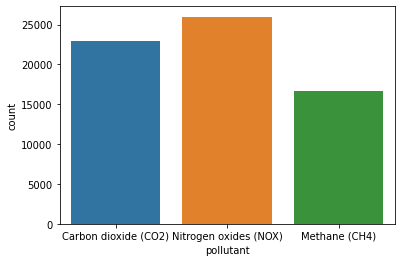

In [13]:
sns.countplot(data=prep_df, x=TARGET)

In [14]:
prep_df.describe(include = np.number).T

,count,mean,std,min,25%,50%,75%,max
reportingYear,90108.0,-35.059928,3.857469,-41.000000,-38.000000,-35.000000,-32.000000,-28.000000
MONTH,90108.0,6.493397,3.447282,1.000000,3.000000,7.000000,9.000000,12.000000
DAY,90108.0,14.543281,8.098556,1.000000,8.000000,15.000000,22.000000,28.000000
max_wind_speed,90108.0,15.512083,3.069792,8.011958,13.311790,15.505221,17.716792,22.991382
avg_wind_speed,90108.0,18.013150,2.311901,14.000100,16.013215,18.017877,20.017578,21.999973
min_wind_speed,90108.0,22.518903,3.060429,15.032589,20.331653,22.535910,24.708091,29.951401
max_temp,90108.0,9.464618,5.222313,-3.159766,5.880222,9.700750,13.296754,20.938266
avg_temp,90108.0,10.457452,5.093656,-0.199916,7.189392,10.711595,14.204277,19.999403
min_temp,90108.0,13.448275,5.228531,0.888248,9.880362,13.698286,17.293781,24.944638
DAY WITH FOGS,90108.0,2.238403,3.782805,0.000000,0.000000,1.000000,2.000000,19.000000


In [15]:
prep_df.describe(exclude = np.number).T

,count,unique,top,freq
countryName,90108,32,United Kingdom,12499
eprtrSectorName,90108,9,Energy sector,33725
EPRTRAnnexIMainActivityLabel,90108,71,Thermal power stations and other combustion in...,29562
FacilityInspireID,90108,7617,https://data.ied_registry.omgeving.vlaanderen....,55
facilityName,90108,8516,Enel Produzione S.p.A.,301
City,90108,5426,--,2713
targetRelease,90108,1,AIR,90108
pollutant,65628,3,Nitrogen oxides (NOX),25982
CONTINENT,90108,1,EUROPE,90108
REPORTER NAME,90108,60488,Michael Smith,34


In [16]:
to_remove = [
    "EPRTRSectorCode",
    "EPRTRAnnexIMainActivityCode",

    "targetRelease",
    "City",
    "CONTINENT",

    "REPORTER NAME" # TEMPORALMENTE, INVESTIGAR
]

prep_df = prep_df.drop(to_remove, axis=1)
print(f"prep_df after drop columns {prep_df.shape}")

prep_df after drop columns (90108, 18)


In [17]:
feature_generator = FeatureGenerator(prep_df)

In [18]:
to_encode = [
    "FacilityInspireID",
    "facilityName",
    "CITY ID",
]

prep_df = feature_generator.encode(to_encode)
print(f"prep_df after encode {prep_df.shape}")

prep_df after encode (90108, 21)


In [19]:
to_one_hot_encode = [
    "countryName",
    "eprtrSectorName",
    "EPRTRAnnexIMainActivityLabel"
]

prep_df = encode_dataframe(prep_df, to_one_hot_encode)

columns to encode: ['countryName', 'eprtrSectorName', 'EPRTRAnnexIMainActivityLabel']
dataframe before one-hot encoding: (90108, 21)
dataframe after one-hot encoding:  (90108, 130)


In [20]:
prep_df[TARGET].unique()

array(['Carbon dioxide (CO2)', 'Nitrogen oxides (NOX)', 'Methane (CH4)',
       nan], dtype=object)

In [21]:
dict_target = {
  "Nitrogen oxides (NOX)": 0,
  "Carbon dioxide (CO2)": 1,
  "Methane (CH4)": 2,
}

In [22]:
prep_df[TARGET] = prep_df[TARGET].apply(lambda value: dict_target[value] if type(value) == str else value)

In [23]:
prep_df[TARGET].unique()

array([ 1.,  0.,  2., nan])

In [24]:
prep_df

,pollutant,reportingYear,MONTH,DAY,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,...,EPRTRAnnexIMainActivityLabel_Opencast mining and quarrying,"EPRTRAnnexIMainActivityLabel_Plants for the pre-treatment (operations such as washing, bleaching, mercerisation) or dyeing of fibres or textiles",EPRTRAnnexIMainActivityLabel_Slaughterhouses,EPRTRAnnexIMainActivityLabel_Thermal power stations and other combustion installations,EPRTRAnnexIMainActivityLabel_Treatment and processing intended for the production of food and beverage products from animal raw materials (other than milk),EPRTRAnnexIMainActivityLabel_Treatment and processing intended for the production of food and beverage products from vegetable raw materials,"EPRTRAnnexIMainActivityLabel_Treatment and processing intended for the production of food and beverage products. Note to reporters, use Level 3 activity e.g. 8(b)(i), in preference to 8(b). Level 2 activity class (i.e. 8(b)) only to be used where Level 3 is not available.",EPRTRAnnexIMainActivityLabel_Treatment and processing of milk,EPRTRAnnexIMainActivityLabel_Underground mining and related operations,EPRTRAnnexIMainActivityLabel_Urban waste-water treatment plants
0,1.0,-33,10,20,15.118767,14.312541,21.419106,2.864895,4.924169,9.688206,...,0,0,0,0,0,0,0,0,0,0
1,0.0,-30,9,21,19.661550,19.368166,21.756389,5.462839,7.864403,12.023521,...,0,0,0,0,0,0,0,0,0,0
2,2.0,-29,2,4,12.729453,14.701985,17.103930,1.511201,4.233438,8.632193,...,0,0,0,0,0,0,0,0,0,0
3,0.0,-36,8,6,11.856417,16.122584,17.537184,10.970301,10.298348,15.179215,...,0,0,0,1,0,0,0,0,0,0
4,2.0,-30,12,22,17.111930,20.201604,21.536012,11.772039,11.344078,16.039004,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90103,NaN,-34,11,16,11.243493,16.527223,18.114884,3.194254,3.901992,6.437241,...,0,0,0,1,0,0,0,0,0,0
90104,NaN,-41,12,13,14.645536,17.044528,24.602476,9.358224,8.708120,13.258552,...,0,0,0,1,0,0,0,0,0,0
90105,NaN,-29,12,12,16.789255,18.595172,24.997173,12.047347,14.686131,17.699271,...,0,0,0,0,0,0,0,0,0,0
90106,NaN,-35,3,24,14.899569,17.112356,19.236777,14.977559,17.846682,20.892999,...,0,0,0,0,0,0,0,0,0,0


In [25]:
dev_df = prep_df[prep_df['test_index'].isnull()]
print('* dev_df loaded... shape:', dev_df.shape)
val_df = prep_df[prep_df['test_index'].notnull()]
print('* val_df loaded... shape:', val_df.shape)


* dev_df loaded... shape: (65628, 130)
* val_df loaded... shape: (24480, 130)


In [26]:
dev_df_X = dev_df.drop([TARGET, 'test_index'], axis = 1)
dev_df_y = dev_df[[TARGET]]
val_df_x = val_df.drop(TARGET, axis = 1)
X_train, X_test, y_train, y_test = train_test_split(dev_df_X, dev_df_y, test_size=0.2, random_state=42)

In [27]:
print(f"""
TRAIN:
    X_train.shape: {X_train.shape}
    y_train.shape: {y_train.shape}
TEST:
    X_test.shape: {X_test.shape}
    y_test.shape: {y_test.shape}
VAL:
    val_df_x.shape: {val_df_x.shape}
""")


TRAIN:
    X_train.shape: (52502, 128)
    y_train.shape: (52502, 1)
TEST:
    X_test.shape: (13126, 128)
    y_test.shape: (13126, 1)
VAL:
    val_df_x.shape: (24480, 129)



In [28]:
model: XGBClassifier = XGBClassifier(
    max_depth=3,
    min_child_weight=100,
    random_state=42,
    use_label_encoder=False,
    objective='multi:softprob',
    learning_rate=0.3,
    n_estimators=200,
)
eval_set = [(X_test, y_test.values.ravel())]
model.fit(
    X_train,
    y_train.values.ravel(),
    eval_metric="merror",
    eval_set=eval_set,
    verbose=True,
    early_stopping_rounds=10,
)

[0]	validation_0-merror:0.409645
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.409645
[2]	validation_0-merror:0.409645
[3]	validation_0-merror:0.409645
[4]	validation_0-merror:0.401722
[5]	validation_0-merror:0.402865
[6]	validation_0-merror:0.395398
[7]	validation_0-merror:0.397455
[8]	validation_0-merror:0.397227
[9]	validation_0-merror:0.395856
[10]	validation_0-merror:0.396465
[11]	validation_0-merror:0.386713
[12]	validation_0-merror:0.385799
[13]	validation_0-merror:0.381457
[14]	validation_0-merror:0.380771
[15]	validation_0-merror:0.379247
[16]	validation_0-merror:0.376886
[17]	validation_0-merror:0.376733
[18]	validation_0-merror:0.376124
[19]	validation_0-merror:0.376505
[20]	validation_0-merror:0.376505
[21]	validation_0-merror:0.376352
[22]	validation_0-merror:0.374524
[23]	validation_0-merror:0.374981
[24]	validation_0-merror:0.375514
[25]	validation_0-merror:0.375362
[26]	validation_0-merror:0.375057
[27]	validation_0-merror:

XGBClassifier(learning_rate=0.3, min_child_weight=100, n_estimators=200,
              objective='multi:softprob', random_state=42,
              use_label_encoder=False)

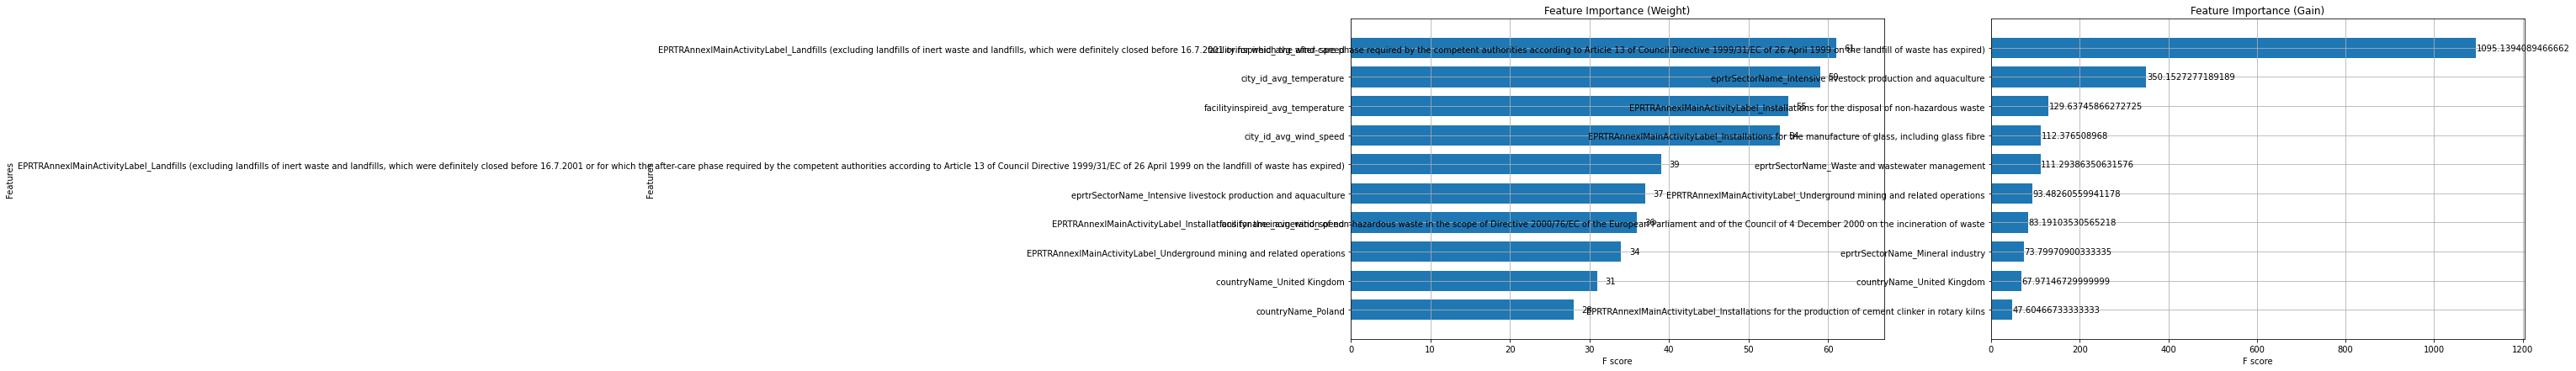

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 7))
# "weight" is the number of times a feature appears in a tree
plot_importance(model, height=0.7, max_num_features=10, ax=ax1, importance_type="weight",
                title="Feature Importance (Weight)")

# "gain" is the average gain of splits which use the feature
plot_importance(model, height=0.7, max_num_features=10, ax=ax2, importance_type="gain",
                title="Feature Importance (Gain)")

In [30]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [31]:
print('f1_score train', f1_score(y_train, y_pred_train, average='macro'))
print('f1_score test', f1_score(y_test, y_pred, average='macro'))


f1_score train 0.6432420871726774
f1_score test 0.6445555521267959


In [32]:
confusion_matrix = pd.crosstab(y_pred, y_test[TARGET])
confusion_matrix

pollutant,0.0,1.0,2.0
row_0,,,
0.0,3827,2862,447
1.0,1251,1630,123
2.0,122,60,2804


In [33]:
y_pred_train = model.predict(X_train)

In [34]:
print(classification_report(y_train, y_pred_train, target_names=['0', '1', '2']))

              precision    recall  f1-score   support

           0       0.53      0.74      0.62     20782
           1       0.55      0.36      0.44     18412
           2       0.94      0.82      0.87     13308

    accuracy                           0.63     52502
   macro avg       0.67      0.64      0.64     52502
weighted avg       0.64      0.63      0.62     52502



In [35]:
val_df_x.set_index('test_index', drop=True, inplace=True)
val_df_x.head()

,reportingYear,MONTH,DAY,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,...,EPRTRAnnexIMainActivityLabel_Opencast mining and quarrying,"EPRTRAnnexIMainActivityLabel_Plants for the pre-treatment (operations such as washing, bleaching, mercerisation) or dyeing of fibres or textiles",EPRTRAnnexIMainActivityLabel_Slaughterhouses,EPRTRAnnexIMainActivityLabel_Thermal power stations and other combustion installations,EPRTRAnnexIMainActivityLabel_Treatment and processing intended for the production of food and beverage products from animal raw materials (other than milk),EPRTRAnnexIMainActivityLabel_Treatment and processing intended for the production of food and beverage products from vegetable raw materials,"EPRTRAnnexIMainActivityLabel_Treatment and processing intended for the production of food and beverage products. Note to reporters, use Level 3 activity e.g. 8(b)(i), in preference to 8(b). Level 2 activity class (i.e. 8(b)) only to be used where Level 3 is not available.",EPRTRAnnexIMainActivityLabel_Treatment and processing of milk,EPRTRAnnexIMainActivityLabel_Underground mining and related operations,EPRTRAnnexIMainActivityLabel_Urban waste-water treatment plants
test_index,,,,,,,,,,,,,,,,,,,,,
0.0,-31,8,16,14.080054,14.855940,18.474836,10.278561,11.381181,13.480752,1,...,0,0,0,0,0,0,0,0,1,0
1.0,-40,11,22,16.052425,17.623877,22.622900,6.625910,8.840137,13.422924,0,...,0,0,0,0,0,0,0,0,0,0
2.0,-34,9,19,13.647318,15.541979,17.818521,5.669436,8.403322,11.276388,2,...,0,0,0,1,0,0,0,0,0,0
3.0,-37,7,17,16.336762,17.458113,19.961777,6.160560,7.571596,9.443572,2,...,0,0,0,0,0,0,0,0,0,0
4.0,-38,6,23,21.516602,20.532473,21.617137,10.964012,11.548033,12.624114,2,...,0,0,0,1,0,0,0,0,0,0


In [36]:
y_pred_test = model.predict(val_df_x)


In [37]:
d = {
    'test_index': val_df_x.reset_index()['test_index'].to_list(), 
     TARGET: y_pred_test
     }
predictions = pd.DataFrame(data=d).astype({'test_index': 'int', TARGET: 'int8'})
predictions

,test_index,pollutant
0,0,2
1,1,2
2,2,1
3,3,2
4,4,0
...,...,...
24475,24475,1
24476,24476,0
24477,24477,2
24478,24478,1


In [40]:
predictions.to_csv(f"{DATA_PATH}/predictions.csv", index=False)

In [41]:
predictions.to_json(f"{DATA_PATH}/predictions.json")